### <span style="color:rgb(234,81,96)">Optimization for Machine Learning</span>
### <span style="color:rgb(234,81,96)">Master 2 IASD Apprentissage, 2023-2024</span>

# <span style="color:rgb(234,81,96)">Lab 06 - Large-scale and distributed optimization</span>


Lecture notes for this course are available [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OAA/PolyOAA.pdf).

This Jupyter notebook can be obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OAA/SourcesLabOAA06.zip).

For any comment regarding this notebook (including typos), please send an email to: **clement.royer@lamsade.dauphine.fr**.

# <span style="color:rgb(234,81,96)">Introduction</span>

In this notebook, we illustrate the performance of several optimization techniques that can prove useful while dealing with large-scale machine learning problems for which the number of variables and/or the number of data points prevents the iterates and the data points to be stored on a single machine. Rather than simulating a distributed environment, we will aim at illustrating the performance of these methods using metrics that are relevant in a distributed setting.

In [26]:
# Preamble: useful toolboxes, librairies, functions, etc.
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Square root

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn # Probability distributions on vectors

# SciPy - Efficient mathematical calculation
from scipy.linalg import norm # Euclidean norm
from scipy.optimize import lsq_linear # Efficient optimizer for least-squares prolbems

# <span style="color:rgb(234,81,96)">Part 1 - Coordinate descent</span>

This part of the notebook is concerned with coordinate descent techniques, that are particularly suitable for 
large-scale problems in which coordinates (or groups thereof) can be updated in a independent fashion. This setting is increasingly common as the dimension of the problem grows.

## <span style="color:rgb(234,81,96)">1.1 Basics of coordinate descent</span>

We first consider the problem 
$$
    \mbox{minimize}_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w}),
$$
where $f$ is supposed to be $\mathcal{C}^1$ and convex. We further assume that $\nabla f$ is *coordinatewise Lipschitz continuous*, that is, there exist $d$ positive constants $L_1,\dots,L_d$ such that
$$
    \forall i=1,\dots,d,\ \forall (\mathbf{w},\mathbf{v}) \in (\mathbb{R}^d)^2, 
    \quad \left| \nabla_i f(\mathbf{w}) - \nabla_i f(\mathbf{v}) \right| 
    \le L_i \|\mathbf{w}-\mathbf{v}\|.
$$
We also define $L_{\max}:= \max_{1 \le i \le d} L_i$.

A possible choice for a constant stepsize is $\alpha_k = \frac{1}{L_{\max}}$.

A typical coordinate descent method starts with $\mathbf{w}_0 \in \mathbf{R}^d$. At every iteration $k$, 
the method picks an iterate $i_k \in \{1,\dots,d\}$, a stepsize $\alpha_k>0$, and performs the following iteration
$$ 
    \mathbf{w}_{k+1} := \mathbf{w}_k - \alpha_k \nabla_{i_k} f(\mathbf{w}_k) \mathbf{e}_{i_k},
$$
where $\nabla_{i_k}$ denotes the partial derivative with respect to the $i_k$th coordinate, i.e.
$\nabla_{i_k} f(\mathbf{w}) = [\nabla f(\mathbf{w})]_{i_k}$ for any $\mathbf{w} \in \mathbb{R}^d$, and $\mathbf{e}_{i_k}$ is the $i_k$th vector of the canonical basis in $\mathbb{R}^d$.

The coordinate descent update can be rewritten as $\mathbf{w}_{k+1}:=\mathbf{w}_k+c_k \mathbf{e}_{i_k}$, where
$$
    c_k = \mbox{argmin}_{c \in \mathbb{R}}\ q_k(c):=\nabla_{i_k} f(\mathbf{w}_k) (c-[\mathbf{w}_k]_{i_k}) 
    + \frac{1}{2\alpha_k}(c-[\mathbf{w}_k]_{i_k})^2.
$$

The value $c_k$ is uniquely defined. Indeed, the function $q_k:\mathbb{R} \rightarrow \mathbb{R}$ is a one-dimensional convex function (a quadratic $t \mapsto a_2 t^2 + a_1 t + a_0$ is convex if and only if $a_2\ge 0$). As a result, $c$ is a (global) minimum of $q_k$ if and only if
$$
    \nabla q_k(c) = 0 \; \Leftrightarrow \; \nabla_{i_k} f(\mathbf{w}_k) + \frac{1}{\alpha_k}(c-[\mathbf{w}_k]_{i_k}) = 0 \; \Leftrightarrow \; c = [\mathbf{w}_k]_{i_k} - \alpha_k \nabla_{i_k} f(\mathbf{w}_k).
$$
As a result, the function $q_k$ has a unique global minimum given by
$$
    c_k = [\mathbf{w}_k]_{i_k} - \alpha_k \nabla_{i_k} f(\mathbf{w}_k).
$$

## <span style="color:rgb(234,81,96)">1.2 Randomized coordinate descent</span>

We now focus on a *randomized* coordinate descent approach, wherein an index $i_k$ is drawn uniformly at random at every iteration in $\{1,\dots,d\}$, and the new iterate is given by 
On considère maintenant des variantes de la descente par coordonnées basée sur une sélection aléatoire des coordonnées.
$$
        \mathbf{w}_{k+1} := \mathbf{w}_k - \frac{\nabla_{i_k} f(\mathbf{w}_k)}{L_{i_k}} \, \mathbf{e}_{i_k},
$$
Here the stepsize is chosen as $\alpha_k=\frac{1}{L_{i_k}}$.

## <span style="color:rgb(234,81,96)">1.3 Coordinate descent and LASSO</span>

We finally apply coordinate descent methods to the LASSO problem (also called *basis pursuit*). Given a data matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$ and a data vector $\mathbf{y} \in \mathbb{R}^d$, this problem can be written as:
$$
    \mbox{minimize}_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w})+ \lambda \|\mathbf{w}\|_1, \qquad 
    f(\mathbf{w}):= \frac{1}{2 n} \|\mathbf{X} \mathbf{w} \|^2.
$$
The function $f$ satisfies the assumptions of the previous part.

We will apply a block-coordinate descent method to this problem. At every iteration, a block of coordinates 
$\mathcal{B}_k \subset \{1,\dots,d\}$ is drawn (uniformly at random), and the new iterate is computed by 
solving:
$$
    \mathbf{w}_{k+1} \in \mbox{argmin}_{\mathbf{w}} f_{\mathcal{B}_k}(\mathbf{w}):= f(\mathbf{w}_k) 
    + \sum_{i \in \mathcal{B}_k} \left\{ 
    \left([\mathbf{w}]_i-[\mathbf{w}_k]_i\right) \nabla_i f(\mathbf{w}_k)+ \frac{L_i}{2} \left([\mathbf{w}]_i-[\mathbf{w}_k]_i\right)^2 
    + \lambda \left| [\mathbf{w}]_i \right| \right\}.
$$
where $L_{i_k}$ is a Lipschitz constant with respect to the $i_k$th coordinate.

### <span style="color:rgb(234,81,96)">One-dimensional case</span>

To help us understand the above subproblem, consider
$$
    \mbox{minimize}_{w \in \mathbb{R}}\ f_1(w):= a (w-u) +  \frac{L}{2} (w-u)^2 + \lambda |w|,
$$
where $a,u \in \mathbb{R}$, $L>0$, and $\lambda \ge 0$. This problem is strongly convex, but the objective function is not differentiable. Its subdifferential is given by:
$$
    \partial f_1(w) := \left\{
        \begin{array}{ll}
            a + L(w-u) + \lambda &\mbox{if $w>0$}\\
            a + L(w-u) -\lambda &\mbox{if $w<0$} \\
            [a + L(w-u)-\lambda,a + L(w-u)+\lambda] &\mbox{if $w=0$.}
        \end{array}
    \right.
$$
Thus, any global solution of the problem $w^*$, satisfies
$$ 
    0 \in \partial f_1(w^*).
$$

Using the subdifferential of $f_1$, we can show that $w^*$ is given by
$$
    w^* = \left\{
        \begin{array}{ll}
            u-\tfrac{a}{L} - \tfrac{\lambda}{L} &\mbox{if $u-\tfrac{a}{L} > \tfrac{\lambda}{L}$} \\
            u-\tfrac{a}{L} + \tfrac{\lambda}{L} &\mbox{if $u-\tfrac{a}{L} < -\tfrac{\lambda}{L}$} \\
            0 &\mbox{if $u-\tfrac{a}{L} \in [-\tfrac{\lambda}{L},\tfrac{\lambda}{L}]$.}
        \end{array}
    \right.
$$


As a result, the block coordinate descent iteration can be rewritten as
$$
    \forall i \in \{1,\dots,d\}, \quad 
    [\mathbf{w}_{k+1}]_i = \left\{
    \begin{array}{ll}
        [\mathbf{w}_k]_i &\mbox{if $i \notin \mathcal{B}_k$} \\
        [\mathbf{w}_k]_i - \tfrac{1}{L_i} \nabla_i f(\mathbf{w}_k) - \tfrac{\lambda}{L_i} &\mbox{if $i \in \mathcal{B}_k$ and } 
        [\mathbf{w}_k]_i - \tfrac{1}{L_i} \nabla_i f(\mathbf{w}_k) > \tfrac{\lambda}{L_i} \\
        [\mathbf{w}_k]_i - \tfrac{1}{L_i} \nabla_i f(\mathbf{w}_k) + \tfrac{\lambda}{L_i} &\mbox{if $i \in \mathcal{B}_k$ and } 
        [\mathbf{w}_k]_i - \tfrac{1}{L_i} \nabla_i f(\mathbf{w}_k) < - \tfrac{\lambda}{L_i} \\
        0 &\mbox{otherwise.}
    \end{array}
    \right.
$$

The code below solves the l1 regularized problem using randomized block coordinate descent.

In [27]:
# Randomized coordinate descent for the LASSO problem
def rcd_lasso(w0,X,y,lbda,nblocks=1,nits=500): 
    """
        Coordinate descent code for LASSO problems of the form
            minimize_w (0.5/n)*||Xw-y||^2 + lbda*||w||_1.
        
        Inputs:
            w0: Initial point
            X: Data matrix
            y: Data vector
            lbda:: Regularization coefficient
            nblocks: Number of coordinates drawn at every iteration
            nits: Maximum number of iterations
            
        Outputs:
            w_output: Last iterate
            objvals: History of function values (Numpy array of length at most nits)
            nnzvals: History of iterate sparsity (Numpy array of length at most nits)
    """
    
    ############
    # Initialization
    objvals = []
    nnzvals = []
    
    # Initial iterate
    w = w0.copy()

    # Iteration index
    k=0    
    
    # Dimensions
    n,d = X.shape
    
    # Lipschitz constants
    ell = norm(np.matmul(X.T,X),axis=0)
    
    # Initial objective value
    obj = norm(X.dot(w) - y) ** 2 / (2. * n)+ lbda * norm(w,1)
    objvals.append(obj)
    # Number of nonzero coefficients
    nnzvals.append(np.count_nonzero(w))
    # Gradient for the smooth part of the objective
    g = X.T.dot(X.dot(w) - y) / n


    #########################
    # Main Loop
    while (k < nits):
        ik = np.random.choice(n,nblocks,replace=False) # Uniform draw without replacement
        
        # Compute the new iterate by changing only one component
        for i in ik:
            vali = w[i]-(1/ell[i])*g[i]
            threshold = (1/ell[i])*lbda
            if vali < -threshold:
                w[i] = vali+threshold
            elif vali > threshold:
                w[i] = vali-threshold
            else:
                w[i] = 0

        # Objective, sparsity level and gradient at the new point
        obj = norm(X.dot(w) - y) ** 2 / (2. * n)+ lbda * norm(w,1)
        objvals.append(obj)
        nnzvals.append(np.count_nonzero(w))
        g = X.T.dot(X.dot(w) - y) / n

        
        k += 1  
    # End Main Loop  
    #######################
    
    w_output = w.copy()
          
    return w_output, np.array(objvals), np.array(nnzvals)

Number of coordinate(s)/it: 1
Objective value: 0.29013074253626253
Percentage nonzero coefficients: 15.0
Number of coordinate(s)/it: 2
Objective value: 0.0003846232091820949
Percentage nonzero coefficients: 0.0
Number of coordinate(s)/it: 10
Objective value: 0.0003846232091820949
Percentage nonzero coefficients: 0.0
Number of coordinate(s)/it: 200
Objective value: 0.0003846232091820949
Percentage nonzero coefficients: 0.0
(5001,)
(5001,)


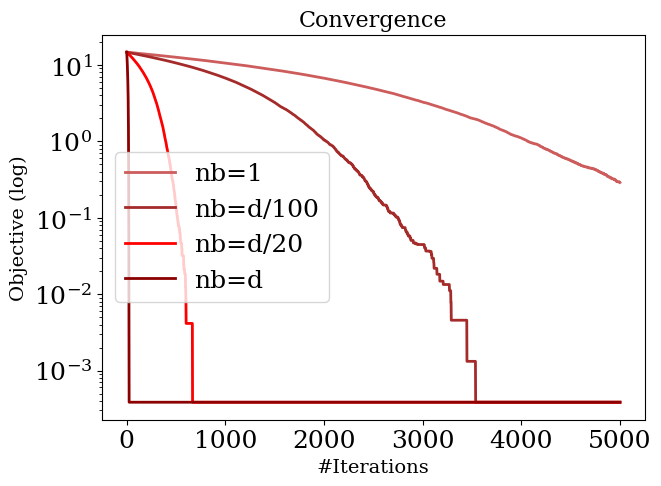

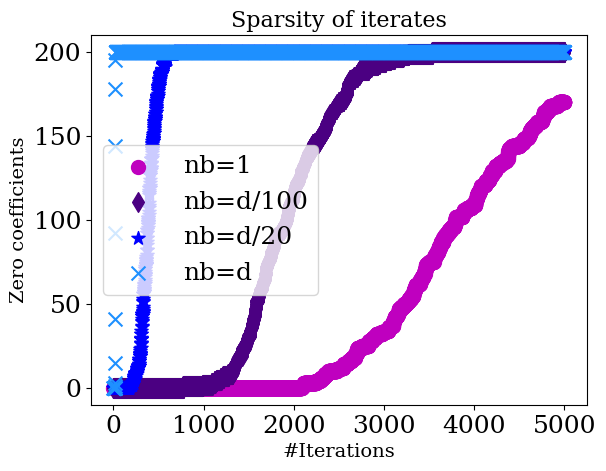

In [28]:
# Experiment with randomized coordinate descent

# Fix random seed for reproducibility
np.random.seed(0)

# Generate data from a sparse ground truth vector
# The coefficients of X follow a normal distribution N(0,1/n)
# The vector y is obtained using y = X*w+eps, where
# w is a sparse vector (10% nonzero coefficients)
d = 200
n = 200
s = round(0.9*min(d,n))
X = multivariate_normal(np.zeros(d), (1/n)*np.identity(d), size=n)
idx = np.arange(d)

# Ground truth
wtrue = (-1)**idx * np.exp(-idx / 10.)
ip = np.random.permutation(d)
wtrue[ip[0:s]]=0

Xw = X.dot(wtrue)
std = (1/n)*(norm(Xw)**2)
noise = std * randn(n)
y = Xw + noise

w0 = np.ones(d)
lbda = 1/ (n**0.5)


################# Test several block values

nb=1
nits=5000
w1,obj1,nnz1 = rcd_lasso(w0,X,y,lbda,nb,nits)
print('Number of coordinate(s)/it:',nb)
print('Objective value:',obj1[-1])
print('Percentage nonzero coefficients:',nnz1[-1]*100/d)
nb=int(d/100)
w2,obj2,nnz2 = rcd_lasso(w0,X,y,lbda,nb,nits)
print('Number of coordinate(s)/it:',nb)
print('Objective value:',obj2[-1])
print('Percentage nonzero coefficients:',nnz2[-1]*100/d)
nb=int(d/20)
w3,obj3,nnz3 = rcd_lasso(w0,X,y,lbda,nb,nits)
print('Number of coordinate(s)/it:',nb)
print('Objective value:',obj3[-1])
print('Percentage nonzero coefficients:',nnz3[-1]*100/d)
nb=d
w4,obj4,nnz4 = rcd_lasso(w0,X,y,lbda,nb,nits)
print('Number of coordinate(s)/it:',nb)
print('Objective value:',obj4[-1])
print('Percentage nonzero coefficients:',nnz4[-1]*100/d)

################# Plot the results across all iterations

# Evolution of the loss
plt.figure(figsize=(7, 5))
plt.semilogy(obj1, label="nb=1", color='indianred',lw=2)
plt.semilogy(obj2, label="nb=d/100", color='brown', lw=2)
plt.semilogy(obj3, label="nb=d/20", color='red', lw=2)
plt.semilogy(obj4, label="nb=d", color='darkred', lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective (log)", fontsize=14)
plt.legend()

# Evolution of the number of zero coordinates
plt.figure()
itnum = np.arange(nits+1)
print(itnum.shape)
print(nnz4.shape)
plt.scatter(itnum,d-nnz1,color='m',marker='o',label='nb=1')
plt.scatter(itnum,d-nnz2,color='indigo',marker='d',label='nb=d/100')
plt.scatter(itnum,d-nnz3,color='b',marker='*',label='nb=d/20')
plt.scatter(itnum,d-nnz4,color='dodgerblue',marker='x',label='nb=d')
plt.title("Sparsity of iterates", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Zero coefficients", fontsize=14)
plt.legend()

The above plots show that selecting a large block size leads to the solution converging quickly to the zero vector, which does not allow for capturing the 10\% nonzero components of the solution. While using a smaller block size, one notices a slower increase in the number of zero components: the final solution with $nb=1$ has 15\% nonzero components, close to the sparsity level of the true solution.

*Note that one could consider another metric than the number of iterations to compare all variants, akin to what was done in the previous labs on stochastic gradient.*

# <span style="color:rgb(234,81,96)">Part 2 - ADMM</span>

The second part of this notebook is concerned with consensus, or network optimization. Considering again our dataset 
$\{(\mathbf{x}_i,y_i)\}_{i=1}^n$, we revisit problem
$$
    \mbox{minimize}_{\mathbf{w} \in \mathbb{R}^d} \frac{1}{n}\sum_{i=1}^n f_i(\mathbf{w}),
$$
by considering that $f_i(\mathbf{w})=(\mathbf{x}_i^T \mathbf{w}-y_i)^2$ is only known of agent $i$ in a network of 
$n$ agents plus one master. All agents work on optimizing their own function in order to reach optimality and consensus. We thus rewrite the problem as
$$
    \mbox{minimize}_{\mathbf{w}^{(1)},\dots,\mathbf{w}^{(n)},\mathbf{w} \in \mathbb{R}^d} \frac{1}{n}\sum_{i=1}^n f_i(\mathbf{w}^{(i)})
    \quad \mbox{s.t.} \quad 
    \mathbf{w}^{(i)} - \mathbf{w} = 0\ \forall i=1,\dots,n.
$$
where agent $i$ can only update $\mathbf{w}^{(i)}$, and a single agent can update $\mathbf{w}$. 
This objective is now separable in the variables.

# <span style="color:rgb(234,81,96)">2.1 Applying ADMM</span>

The $k$-th iteration of ADMM for this problem is as follows:
$$
    \left\{
        \begin{array}{lll}
            \mathbf{w}_{k+1} &:= &\frac{1}{n}\sum_{i=1}^n \left(\mathbf{w}^{(i)}_k - \frac{1}{\lambda} \mathbf{z}_k \right) \\
            \mathbf{w}^{(i)}_{k+1} &:= &\mbox{argmin}_{\mathbf{u}} \left\{ f_i(\mathbf{u}) + \mathbf{z}_k^T \mathbf{u} 
            + \frac{\lambda}{2} \|\mathbf{u}-\mathbf{w}_{k+1}\|^2  \right\} 
            \quad \forall i=1,\dots,n,\\
            \mathbf{z}_{k+1} &:= &\mathbf{z}_k + \lambda \sum_{i=1}^n \left(\mathbf{w}_{k+1}^{(i)}-\mathbf{w}_{k+1}\right) 
        \end{array}
    \right.
$$

The objective function for the subproblem is
$$
    \frac{1}{2} (\mathbf{x}_i^T \mathbf{u} - y_i)^2 + \mathbf{z}_k^T \mathbf{u} +\frac{\lambda}{2} \|\mathbf{u}-\mathbf{w}_{k+1}\|^2,
$$
which is a quadratic function of the form $\tfrac{1}{2}\mathbf{u}^T \mathbf{H} \mathbf{u} - \mathbf{g}^T \mathbf{u}$ with $\mathbf{H} = \mathbf{I}_d+\mathbf{x}_i \mathbf{x}_i^T \in \mathbf{R}^{(d+1)\times d}$ and linear term $\mathbf{g}=y_i \mathbf{x}_i+z_k$.

In [29]:
# ADMM for consensus least squares
def admm_ls(w0,z0,lbda,nits=100,verbose=True): 
    """
        ADMM 
            minimize_w (0.5/n)*sum_{i=1}^n (x_i^T w - y_i)^2.
        
        Inputs:
            w0: Initial point
            z0: Initial dual variable
            lbda: Parameter for the augmented lagrangian
            nits: Number of iterations
            verbose: Boolean for plotting iteration statistics
            
        Outputs:
            w_output: Last iterate
            z_output: Last dual variable
            objvals: History of function values (Numpy array of length at most nits)
            consvals: History of consensus (Numpy array of length at most nits)
    """
    
    ############
    # Initialization
    objvals = []
    consvals = []

    # Dimensions
    n,d = X.shape
    
    
    # Initial iterate
    w = w0.copy()
    Ws = np.outer(np.ones(n),w)
    z = z0.copy()

    # Iteration index
    k=0    
    

    # Lipschitz constants
    ell = norm(np.matmul(X.T,X),axis=0) /n
    
    # Initial objective value
    obj = norm(X.dot(w) - y) ** 2 / (2. * n)
    objvals.append(obj)
    
    # Initial consensus
    c = np.sum(Ws,axis=0)
    print(c.shape)
    cons = norm(c-n*w)
    consvals.append(cons)
    
    if verbose:
        print("ADMM:")
        print(' | '.join([name.center(8) for name in ["iter", "fval","cons"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % cons).rjust(8)]))


    #########################
    # Main Loop
    while (k < nits):
        
        w = (1/n)*(c-(1/lbda)*z)
        
        for i in range(n):
            xi = X[i]
            Ws[i,:] = lsq_linear(np.eye(d)+np.outer(xi,xi), y[i]*xi-z, bounds=(None,None)).x
        
        c = np.sum(Ws,axis=0)
        z += ell*(c-n*w)
                                           

        # Objective and consensus at the new point
        obj = norm(X.dot(w) - y) ** 2 / (2. * n)
        objvals.append(obj)
        cons = norm(c-n*w)
        consvals.append(cons)

        k += 1 
        
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % cons).rjust(8)]))      

        
 
    # End Main Loop  
    #######################
    
    w_output = w.copy()
    z_output = z.copy()
          
    return w_output,z_output, np.array(objvals), np.array(consvals)

# <span style="color:rgb(234,81,96)">2.2 Test on a simple instance</span>

(30,)


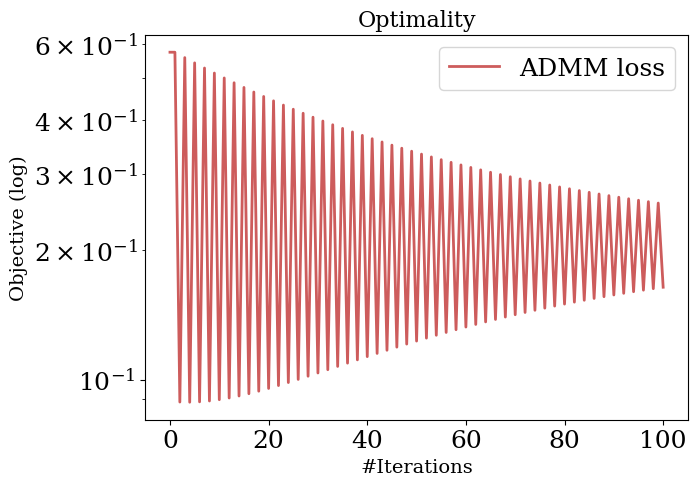

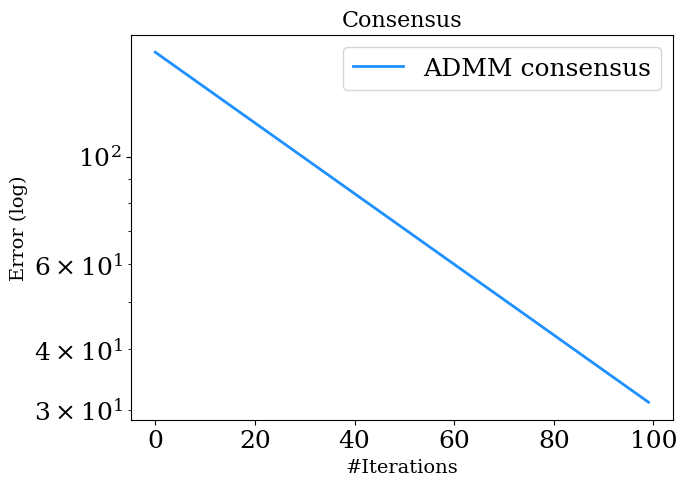

In [30]:
# Basic test for ADMM (small dimensional)

d=30
n=30

# Fix random seed for reproducibility
np.random.seed(0)

# Generate data from a  ground truth vector
#X = multivariate_normal(np.zeros(d), (1/n)*np.identity(d), size=n)
X = np.identity(n)
idx = np.arange(d)

# Ground truth
wtrue = (-1)**idx * np.exp(-idx / 10.)

y = X.dot(wtrue)
#Xw = X.dot(wtrue)
#std = (0.01/n)*(norm(Xw)**2)
#noise = std * randn(n)
#y = Xw + noise

w0 = np.ones(d)
z0 = np.zeros(d)
lbda = 1000

[wout,zout,objvals,consvals]=admm_ls(w0,z0,lbda,nits=100,verbose=False)

# Evolution of the loss
plt.figure(figsize=(7, 5))
plt.semilogy(objvals, label="ADMM loss", color='indianred',lw=2)
plt.title("Optimality", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective (log)", fontsize=14)
plt.legend()

# Evolution of the consensus
plt.figure(figsize=(7, 5))
plt.semilogy(consvals[1:], label="ADMM consensus", color='dodgerblue',lw=2)
plt.title("Consensus", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Error (log)", fontsize=14)
plt.legend()

The loss function converges (though not monotonically) towards a certain value, while the consensus error converges linearly towards 0.

In [31]:
# Version 4.0 - C. W. Royer, November 2023.